In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from typing import Union

# Data Exploration

## Question: What do our different data schema look like?

In [2]:
features:pd.DataFrame = pd.read_csv('data/features.csv')
print(features.info())
print(features.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   feature_num   143 non-null    int64 
 1   case_num      143 non-null    int64 
 2   feature_text  143 non-null    object
dtypes: int64(2), object(1)
memory usage: 3.5+ KB
None
   feature_num  case_num                                       feature_text
0            0         0  Family-history-of-MI-OR-Family-history-of-myoc...
1            1         0                 Family-history-of-thyroid-disorder
2            2         0                                     Chest-pressure
3            3         0                              Intermittent-symptoms
4            4         0                                        Lightheaded


In [3]:
patient_notes:pd.DataFrame = pd.read_csv('data/patient_notes.csv');
print(patient_notes.info())
print(patient_notes.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42146 entries, 0 to 42145
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pn_num      42146 non-null  int64 
 1   case_num    42146 non-null  int64 
 2   pn_history  42146 non-null  object
dtypes: int64(2), object(1)
memory usage: 987.9+ KB
None
   pn_num  case_num                                         pn_history
0       0         0  17-year-old male, has come to the student heal...
1       1         0  17 yo male with recurrent palpitations for the...
2       2         0  Dillon Cleveland is a 17 y.o. male patient wit...
3       3         0  a 17 yo m c/o palpitation started 3 mos ago; \...
4       4         0  17yo male with no pmh here for evaluation of p...


In [4]:
train:pd.DataFrame = pd.read_csv('data/train.csv');
print(train.info())
print(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14300 entries, 0 to 14299
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           14300 non-null  object
 1   case_num     14300 non-null  int64 
 2   pn_num       14300 non-null  int64 
 3   feature_num  14300 non-null  int64 
 4   annotation   14300 non-null  object
 5   location     14300 non-null  object
dtypes: int64(3), object(3)
memory usage: 670.4+ KB
None
          id  case_num  pn_num  feature_num  \
0  00016_000         0      16            0   
1  00016_001         0      16            1   
2  00016_002         0      16            2   
3  00016_003         0      16            3   
4  00016_004         0      16            4   

                                 annotation              location  
0          ['dad with recent heart attcak']           ['696 724']  
1             ['mom with "thyroid disease']           ['668 693']  
2                   

So it looks like we have three different fundamental indices: case_num (the case to which something belongs), pn_num (the patient note to which something belongs), and feature_num (the feature to which something belongs).

In our training data, each row has a pn_num, a case_num, and a feature_num along wtih the text(s) indicating the feature and the location span(s) for that feature. Thus it is saying for every patient note and every feature present in that note, where was that feature found (note that some patient notes may not have features). The case_num seems redundant with the pn_num because patient_notes also has the case_num. 

Also, we only have 14,300 train entries whereas we have 42k patient notes, so many patient notes are going un-annotated. The next question I would have is how many patient notes actually have annotation, and what is the distribution of feature counts associated with patient notes (to figure out whether we have a bunch of rows in our train set for just a few notes). It also could be useful to see how many distinct patient notes we have representing each feature and how many annotations we have per case number


## Question: How many patient notes actually have annoation?

In [5]:
train.pn_num.nunique()

1000

There are 1000 notes with annotation, confirming what was in [Kaggle](https://www.kaggle.com/c/nbme-score-clinical-patient-notes/data?select=train.csv).

In [6]:
train.case_num.nunique()

10

In [7]:
train.groupby('case_num').pn_num.nunique()

case_num
0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
Name: pn_num, dtype: int64

Each of the 10 cases has 100 patient notes annotated with them. 

In [8]:
train.groupby('feature_num').pn_num.nunique().describe()

count    143.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
Name: pn_num, dtype: float64

Every feature given (143 of them) has 100 total notes that have it. Very nice balance!

The next step I see is to merge these into one dataframe for easier analysis.

## Action: Merge all notes indicated in train set into a single dataframe

In [9]:
merged_df = train.merge(patient_notes, on='pn_num', how='left').merge(features, on='feature_num', how='left')
merged_df.head(20)

,id,case_num_x,pn_num,feature_num,annotation,location,case_num_y,pn_history,case_num,feature_text
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],0,HPI: 17yo M presents with palpitations. Patien...,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],0,HPI: 17yo M presents with palpitations. Patien...,0,Family-history-of-thyroid-disorder
2,00016_002,0,16,2,['chest pressure'],['203 217'],0,HPI: 17yo M presents with palpitations. Patien...,0,Chest-pressure
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",0,HPI: 17yo M presents with palpitations. Patien...,0,Intermittent-symptoms
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],0,HPI: 17yo M presents with palpitations. Patien...,0,Lightheaded
5,00016_005,0,16,5,[],[],0,HPI: 17yo M presents with palpitations. Patien...,0,No-hair-changes-OR-no-nail-changes-OR-no-tempe...
6,00016_006,0,16,6,"['adderall', 'adderrall', 'adderrall']","['321 329', '404 413', '652 661']",0,HPI: 17yo M presents with palpitations. Patien...,0,Adderall-use
7,00016_007,0,16,7,[],[],0,HPI: 17yo M presents with palpitations. Patien...,0,Shortness-of-breath
8,00016_008,0,16,8,[],[],0,HPI: 17yo M presents with palpitations. Patien...,0,Caffeine-use
9,00016_009,0,16,9,"['palpitations', 'heart beating/pounding']","['26 38', '96 118']",0,HPI: 17yo M presents with palpitations. Patien...,0,heart-pounding-OR-heart-racing


Let's view just this first patient note to get a sense of what we have

## Question: How do annotations look in the notes?

In [10]:
pd.set_option('display.max_colwidth', None)
first_note = merged_df.query('pn_num == 16')
first_note[['feature_text', 'annotation', 'location']]

,feature_text,annotation,location
0,Family-history-of-MI-OR-Family-history-of-myocardial-infarction,['dad with recent heart attcak'],['696 724']
1,Family-history-of-thyroid-disorder,"['mom with ""thyroid disease']",['668 693']
2,Chest-pressure,['chest pressure'],['203 217']
3,Intermittent-symptoms,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,Lightheaded,['felt as if he were going to pass out'],['222 258']
5,No-hair-changes-OR-no-nail-changes-OR-no-temperature-intolerance,[],[]
6,Adderall-use,"['adderall', 'adderrall', 'adderrall']","['321 329', '404 413', '652 661']"
7,Shortness-of-breath,[],[]
8,Caffeine-use,[],[]
9,heart-pounding-OR-heart-racing,"['palpitations', 'heart beating/pounding']","['26 38', '96 118']"


In [11]:
print(first_note.loc[0, 'pn_history'])

HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. 
PMHx: none
Rx: uses friends adderrall
FHx: mom with "thyroid disease," dad with recent heart attcak
All: none
Immunizations: up to date
SHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms


A few notes here
1. As suspected, the features with no annotation are not present in the note; this is useful
2. There are many ways to express features (e.g. lightheaded = 'felt as if he were going to pass out')
3. Some small words, e.g. 'M' are very important for indicating a feature. Either these should be identified manually (this is prone to error since we only have so many annotations) or we need to keep input as raw text. It may be that deep learning models do not have any issue with mispelling. 

Let's view a second note to get a second perspective:

In [12]:
pd.set_option('display.max_colwidth', None)
second_note = merged_df.query('pn_num == 41')
second_note[['feature_text', 'annotation', 'location']]

,feature_text,annotation,location
13,Family-history-of-MI-OR-Family-history-of-myocardial-infarction,[],[]
14,Family-history-of-thyroid-disorder,['MOM HAS THYROID PROBLEMS'],['532 556']
15,Chest-pressure,['PRESSURE ON HER CHEST'],['263 284']
16,Intermittent-symptoms,"['COMES AND GOES', 'HAPPENED 5-6 TIMES']","['131 145', '150 168']"
17,Lightheaded,[],[]
18,No-hair-changes-OR-no-nail-changes-OR-no-temperature-intolerance,[],[]
19,Adderall-use,[],[]
20,Shortness-of-breath,['SOB'],['258 261']
21,Caffeine-use,[],[]
22,heart-pounding-OR-heart-racing,['HEART POUNDING'],['32 46']


In [13]:
print(second_note.iloc[0]['pn_history'])

17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING. STARTED 2-3 MO AGO. IT STARTED SUDDENLY. DOES NOT RECALL ANY TRIGGERING EVENTS. IT COMES AND GOES, IT HAPPENED 5-6 TIMES SINCE IT STARTED. IT LASTS 3-4 MIN, AFTER THAN  JUST GOES AWAY. HE HAS ALSO EXPERIENCING SOB, PRESSURE ON HER CHEST WHEN HE HAS THIS ATTACK. HE IS A COLLEGE STUDENT, EXPERIENCING SOME STRESS RECENTLY. 
DENIES COUGH, CHEST PAIN.
ROS NEG EXCEPT AS ABOVE.
PMH NONE. MEDS ATEROL, FOR HIS STUDIES, SHARING W HIS ROOMMATE. NKDA.
PSH/ HOSP/ TRAVEL/ TRAUMA NONE.
FH MOM HAS THYROID PROBLEMS.
SH SEX ACTIVE W GIRLFRIEND, NO STDS, USING CONDOMS. SMOKE NONE. ETOH ONLY WEEKENDS. DRUG ONLY ONCE, 1 MO AGO.


Again many ways things can be expressed, will need some help understanding HOSP/TRAVEL and ETOH ONLY ON WEEKENDS. Also note the confusing use of PRESSURE ON HER CHEST with this being a male patient!

Now that we have a better idea of the data it is probably best to begin to make a toy task to get some initial results. I will go wtih trying to predict the existence or non-existence of a feature for a patient note. Note that both mentioned features that should be there and are not, as well as features that are not mentioned, are all not there. However the ones that should be there and are not are in some sense more likely to be misclassified as they are more related. 

## Action: Create a dataframe with the notes and whether a feature is present or not

In [14]:
all_features = set(features.feature_text.unique())
patient_num = 41
def get_note_and_features(patient_num: int, merged_df: pd.DataFrame, all_features: set):
    this_note_data:pd.DataFrame = merged_df.query(f'pn_num == {patient_num}')
    features_present = set()
    for (feature_name, feature_num, annotation) in this_note_data[['feature_text', 'feature_num', 'annotation']].itertuples(index=False):
        feature_is_present = len(eval(annotation)) > 0
        if feature_is_present:
            features_present.add(feature_name)
    features_not_present = all_features.difference(features_present)
    return pd.Series([this_note_data['pn_history'].iloc[0], *np.ones(len(features_present)), *np.zeros(len(features_not_present))], index=['pn_history'] + list(features_present) + list(features_not_present))

present_df = pd.DataFrame([get_note_and_features(patient_num, merged_df, all_features) for patient_num in merged_df.pn_num.unique()])

In [15]:
print(present_df.info(verbose=True))
print(present_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 132 columns):
 #    Column                                                                Dtype  
---   ------                                                                -----  
 0    pn_history                                                            object 
 1    Family-history-of-MI-OR-Family-history-of-myocardial-infarction       float64
 2    Lightheaded                                                           float64
 3    Adderall-use                                                          float64
 4    Chest-pressure                                                        float64
 5    17-year                                                               float64
 6    Family-history-of-thyroid-disorder                                    float64
 7    Few-months-duration                                                   float64
 8    Male                                           

<AxesSubplot:>

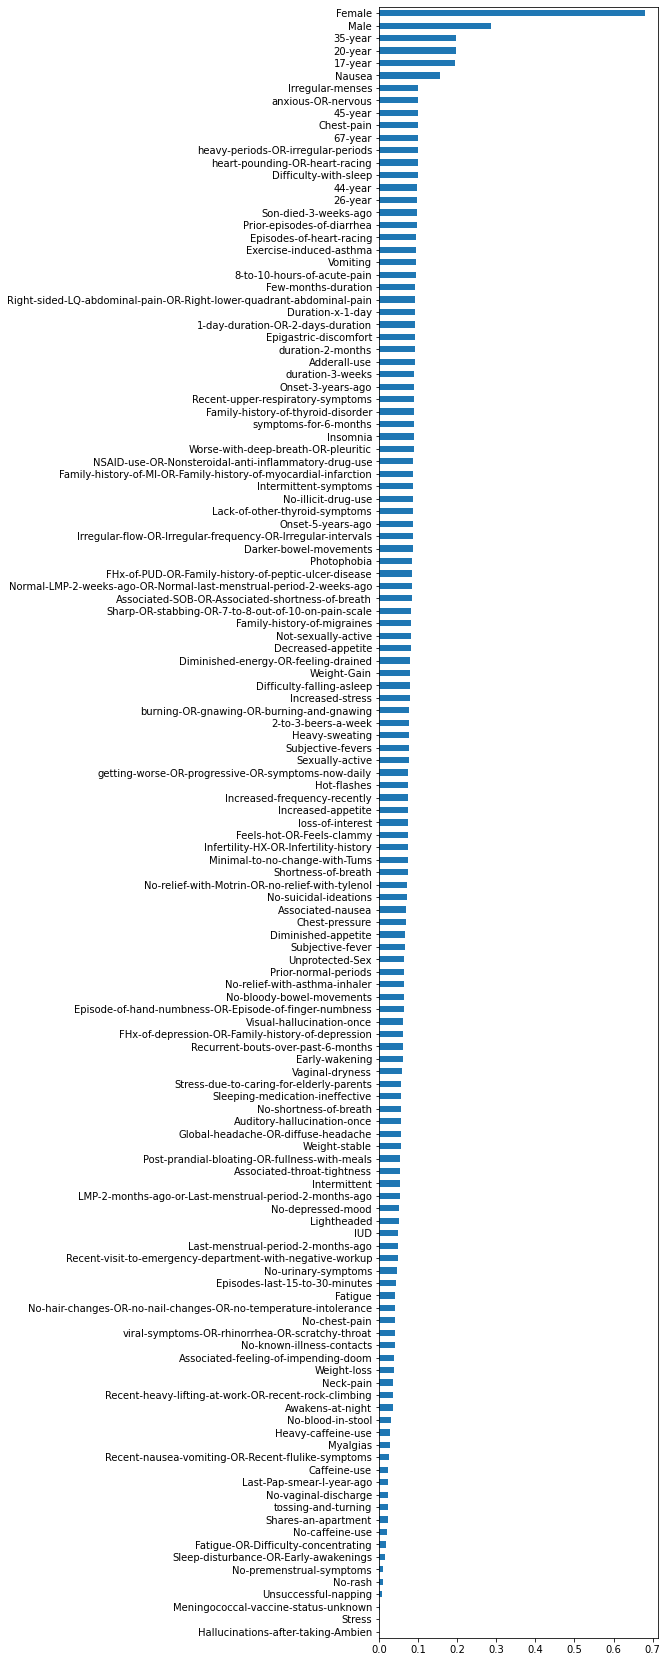

In [16]:
present_df.select_dtypes(exclude=['object']).mean().sort_values().plot(kind='barh', figsize=(5, 30))

Clearly some features barely show up, while female and male by far dominate. A much easier task, then, is going to be to just try to predict whether the note is describing a female or male individual. Note that this is non-trivial as some notes are ambiguous (e.g. the second described "pressure on HER chest")

In [17]:
present_df.query('(Female == 1) & (Male == 1)')

,pn_history,Family-history-of-MI-OR-Family-history-of-myocardial-infarction,Lightheaded,Adderall-use,Chest-pressure,17-year,Family-history-of-thyroid-disorder,Few-months-duration,Male,heart-pounding-OR-heart-racing,...,2-to-3-beers-a-week,Irregular-flow-OR-Irregular-frequency-OR-Irregular-intervals,Recent-upper-respiratory-symptoms,No-rash,Difficulty-falling-asleep,Associated-SOB-OR-Associated-shortness-of-breath,Recent-visit-to-emergency-department-with-negative-workup,Episode-of-hand-numbness-OR-Episode-of-finger-numbness,Heavy-sweating,Prior-normal-periods


Fortunately there are no notes that have both! 

In [18]:
len(present_df.query('(Female == 0) & (Male == 0)'))

34

There are, however, some notes that have neither

# A model to predict the presence of sex features

In [19]:
data = present_df.query('(Female != 0) | (Male != 0)')[['pn_history', 'Male']]  # We can just predict whether the patient is male to get if they are female
print(f'We have {len(data)} datapoints')
train, test = train_test_split(data)
print(f'We have {len(train)} train points and {len(test)} test points')

We have 966 datapoints
We have 724 train points and 242 test points


We should begin by comparing to a simple baseline which just looks at the note for things like 'Man', " M " , " F ", etc.. any machine learning strategy should be able to beat these.

## A simple baseline

In [20]:
class SimpleClassifier(ClassifierMixin, BaseEstimator):
    MALE_INDICATORS = {'MAN', 'M', 'MALE', 'GUY', 'DUDE', 'BOY', 'GENTLEMAN', 'GENT', 'HIS', 'HIM', 'HE'}
    FEMALE_INDICATORS = {'WOMAN', 'W', 'SHE', 'LADY', 'FEMALE', 'HER', 'HERS'}

    def predict(self, X: Union[pd.DataFrame, pd.Series, list]) -> np.array:
        assert len(X.shape) == 1 or X.shape[1] == 1, 'can only fit on text'
        out = []
        for t in X:
            cleaned = list(map(lambda s: s.upper(), t.split()))
            male = any(mi in cleaned for mi in self.MALE_INDICATORS)
            female = any(fi in cleaned for fi in self.FEMALE_INDICATORS)
            if male and not female:
                out.append(1)
            elif not male and female:
                out.append(0)
            else:
                out.append(0.5)
        return np.array(out)

In [21]:
roc_auc_score(train['Male'], SimpleClassifier().predict(train['pn_history']))

0.9791302883379572

In [22]:
prediction_indices = np.argwhere(SimpleClassifier().predict(train['pn_history']) != 0.5).flatten()
print(classification_report(train['Male'].to_numpy()[prediction_indices], SimpleClassifier().predict(train['pn_history'])[prediction_indices]))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       384
         1.0       0.97      1.00      0.98       204

    accuracy                           0.99       588
   macro avg       0.98      0.99      0.99       588
weighted avg       0.99      0.99      0.99       588



That is shockingly good, but note that the support is appreciably lower than the size of the training set. 

## A deep learning based approach

Given the complexities of the text input I see no better approach that just going to deep learning from the getgo as a feature extraction mechanism. However we can try a few different ways to convert features into predictions, I imagine XGboost is going to work the best.

In [23]:
from transformers import BartTokenizer, BartModel
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartModel.from_pretrained('facebook/bart-base')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

Downloading: 100%|██████████| 532M/532M [00:14<00:00, 37.5MB/s] 


In [25]:
last_hidden_states.shape

torch.Size([1, 8, 768])

In [26]:
?BartTokenizer

Init signature:
BartTokenizer(
    vocab_file,
    merges_file,
    errors='replace',
    bos_token='<s>',
    eos_token='</s>',
    sep_token='</s>',
    cls_token='<s>',
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>',
    add_prefix_space=False,
    **kwargs,
)
Docstring:     
Constructs a BART tokenizer, which is smilar to the ROBERTa tokenizer, using byte-level Byte-Pair-Encoding.

This tokenizer has been trained to treat spaces like parts of the tokens (a bit like sentencepiece) so a word will
be encoded differently whether it is at the beginning of the sentence (without space) or not:

```
>>> from transformers import BartTokenizer
>>> tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
>>> tokenizer("Hello world")['input_ids']
[0, 31414, 232, 2]
>>> tokenizer(" Hello world")['input_ids']
[0, 20920, 232, 2]
```

You can get around that behavior by passing `add_prefix_space=True` when instantiating this tokenizer or when you
call it on some text,